In [1]:
import os
import json
import hoomd
import codecs

import numpy as np

import polychrom_hoomd.log as log
import polychrom_hoomd.build as build
import polychrom_hoomd.forces as forces
import polychrom_hoomd.render as render
import polychrom_hoomd.extrude as extrude

from lattice_translocators.generators.Translocator import Translocator
from lattice_translocators.engines.SymmetricExtruder import SymmetricExtruder

from polykit.generators.initial_conformations import grow_cubic


In [2]:
# Initialise HOOMD on the CPU or GPU, based on availability
hoomd_device = build.get_hoomd_device()

HOOMD is running on the following GPU(s):
[0] NVIDIA A100-PCIE-40GB 108 SM_8.0 @ 1.41 GHz, 40339 MiB DRAM


In [3]:
# Generate RNG seed
rng_seed = os.urandom(2)
rng_seed = int(codecs.encode(rng_seed, 'hex'), 16)

print("Using entropy-harvested random seed: %d" % rng_seed)

Using entropy-harvested random seed: 12026


In [4]:
# Initialize empty simulation object
system = hoomd.Simulation(device=hoomd_device, seed=rng_seed)

In [5]:
# Simulate two chromosomes comprised of 5000 (resp. 10000) monomers each, with number density 0.2
density = 0.2
chromosome_sizes = [5000, 10000]

In [6]:
# Confine chromosomes within a sphere of appropriate radius
number_of_monomers = sum(chromosome_sizes)
confinement_radius = (3*number_of_monomers / (4*np.pi*density))**(1/3.)

In [7]:
# Set simulation box large enough to accomodate the chromosomes
snapshot = build.get_simulation_box(box_length=2*confinement_radius, pad=1.)

In [8]:
# Build random, dense initial conformations
inscribed_cube_length = confinement_radius*2/3**.5
monomer_positions = grow_cubic(N=number_of_monomers, boxSize=int(inscribed_cube_length))

In [9]:
# Parse force parameters
with open("force_dict_full.json", 'r') as dict_file:
    force_dict = json.load(dict_file)

In [10]:
# Parse particle/bond types
bond_types = force_dict['Bonded forces'].keys()
angle_types = force_dict['Angular forces'].keys()
monomer_types = force_dict['Non-bonded forces']['Attraction']['Matrix'].keys()

In [11]:
# Populate snapshot with the generated chains
build.set_chromosomes(snapshot, monomer_positions, chromosome_sizes,
                      bond_type_list=list(bond_types), monomer_type_list=list(monomer_types),
                      angle_type_list=list(angle_types))

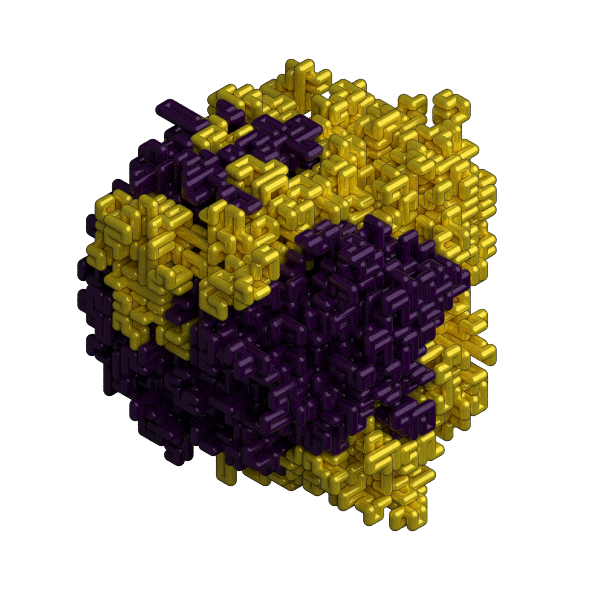

In [12]:
# Render individual chromosomes using the Fresnel backend
render.fresnel(snapshot, show="chromosomes").static()

In [13]:
# Setup domains by assigning monomers to a type 0 (A) or 1 (B)
domain_size = 500

motif = np.zeros(3*domain_size)
motif[domain_size:2*domain_size] = 1

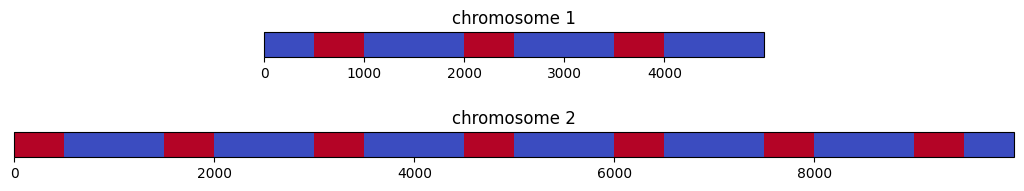

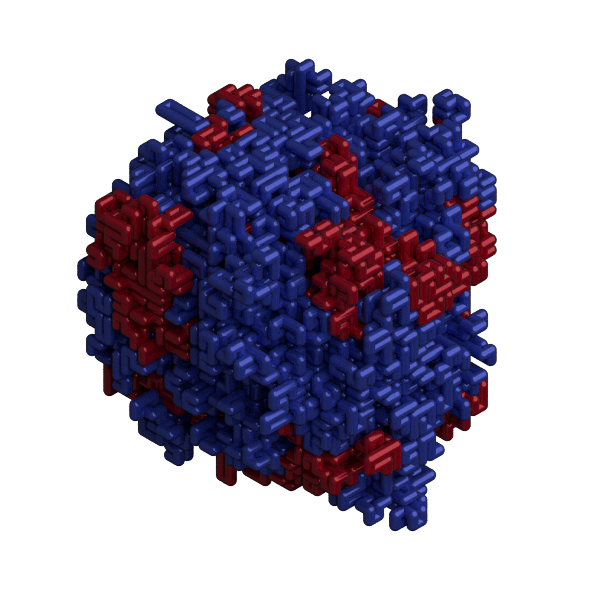

In [14]:
# Assign and visualize domains in 1D/3D
snapshot.particles.typeid[:] = np.tile(motif, number_of_monomers//motif.shape[0])

render.domain_viewer(snapshot, cmap="coolwarm")
render.fresnel(snapshot, show="compartments", cmap="coolwarm").static()

In [15]:
# Setup HooMD simulation object
system.create_state_from_snapshot(snapshot)

In [16]:
# Setup neighbor list
nl = hoomd.md.nlist.Cell(buffer=0.4)

In [17]:
# Set chromosome excluded volume
repulsion_forces = forces.get_repulsion_forces(nl, **force_dict)

In [18]:
# Set bonded/angular potentials
bonded_forces = forces.get_bonded_forces(**force_dict)
angular_forces = forces.get_angular_forces(**force_dict)

In [19]:
# Set spherical confining wall
force_dict['External forces']['Confinement']['Spherical'] = dict(R=confinement_radius)
confinement_forces = forces.get_confinement_forces(**force_dict)

In [20]:
# Set attractive/DPD forces
dpd_forces = forces.get_dpd_forces(nl, **force_dict)
attraction_forces = forces.get_attraction_forces(nl, **force_dict)

Setting up DPD with the conservative force contribution disabled


In [21]:
# Define full force_field
force_field = repulsion_forces + bonded_forces + angular_forces + confinement_forces \
            + dpd_forces + attraction_forces

In [22]:
# Setup DPD integrator
nve = hoomd.md.methods.NVE(filter=hoomd.filter.All())
dpd_integrator = hoomd.md.Integrator(dt=5e-3, methods=[nve], forces=force_field)

/home1/tortora/.conda/envs/multistate/lib/python3.10/site-packages/hoomd/md/methods/methods.py:699: FutureWarning: NVE is deprecated and wil be removed in hoomd 4.0. In version 4.0, use the ConstantVolume method without a thermostat.
  warnings.warn(


In [23]:
# Setup log and simulation engines
logger = log.get_logger(system)

system.operations.integrator = dpd_integrator
system.operations.writers.append(log.table_formatter(logger, period=10000))

In [24]:
# Run
system.run(1e5)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
       10000           4840.53912     0:00:18.592970           0.92093          
       20000           5974.70363     0:00:13.389785           0.99220          
       30000           6469.13301     0:00:10.820615           1.00398          
       40000           6748.17200     0:00:08.891297           1.02971          
       50000           6910.52556     0:00:07.235340           1.02037          
       60000           7022.65077     0:00:05.695855           1.02801          
       70000           7077.71309     0:00:04.238657           1.02346          
       80000           7127.27050     0:00:02.806123           1.04014          
       90000           7176.64642     0:00:01.393408           1.03561          
      100000           7215.90604        0:00:00               1.03802          


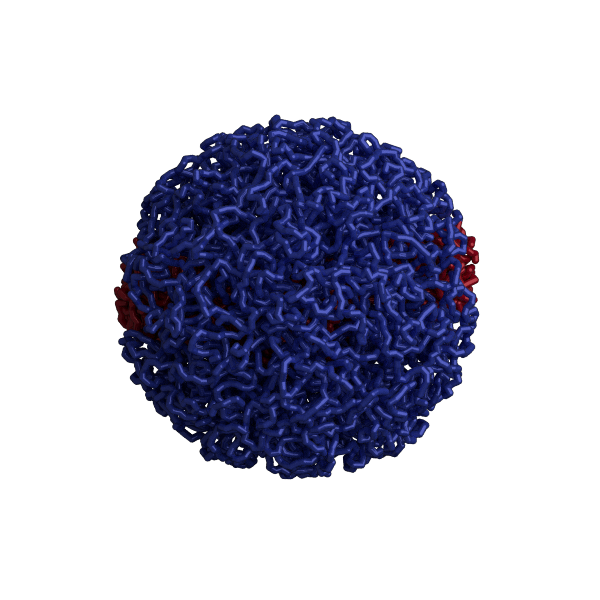

In [25]:
# Visualize equilibrated domains in 3D
snapshot_equilibrated = system.state.get_snapshot()
render.fresnel(snapshot_equilibrated, show="compartments", cmap="coolwarm").static()

In [26]:
# Parse extrusion parameters
with open("extrusion_dict.json", 'r') as dict_file:
    extrusion_dict = json.load(dict_file)

In [27]:
# Create some CTCF boundary sites
tad_size = 100 # in monomers

ctcf_left_positions = np.arange(0, number_of_monomers, tad_size)
ctcf_right_positions = np.arange(0, number_of_monomers, tad_size)

In [28]:
# Create translocator object
translocator = Translocator(SymmetricExtruder, 
                            snapshot.particles.types,
                            snapshot.particles.typeid,
                            ctcf_left_positions,
                            ctcf_right_positions, 
                            **extrusion_dict)

In [29]:
# Precompute extruder positions
translocator.run()

extrude.update_topology(system, translocator.lef_trajectory[0])

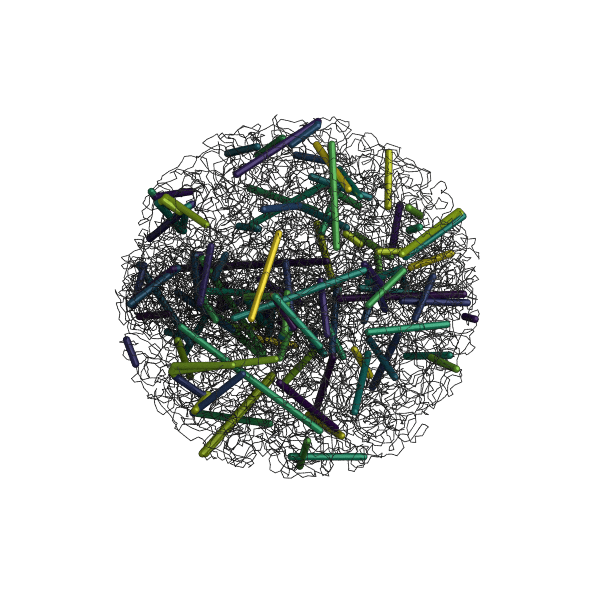

In [30]:
# Visualize new extrusion bonds 
snapshot_looped = system.state.get_snapshot()
render.fresnel(snapshot_looped, show="loops", rescale_backbone_bonds=0.1).static()

In [31]:
# Define relaxation force field
relax_field = repulsion_forces + bonded_forces + confinement_forces

In [32]:
# Relax CTCF bonds via the fast inertial relaxation engine
system.operations.remove(dpd_integrator)
system.operations.remove(system.operations.writers[0])

fire = hoomd.md.minimize.FIRE(dt=1e-2, methods=[nve], forces=relax_field,
                              force_tol=5e-2, angmom_tol=5e-2, energy_tol=5e-2)

In [33]:
# Update simulation engine
system.operations.integrator = fire
system.operations.writers.append(log.table_formatter(logger, period=500))

In [34]:
# Run
system.run(5e3)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
      100500           1071.26833     0:00:04.200628           0.00003          
      101000           2135.73802     0:00:01.872889           0.00003          
      101500           3194.28906     0:00:01.095705           0.00003          
      102000           4249.85490     0:00:00.705906           0.00003          
      102500           5299.22940     0:00:00.471767           0.00003          
      103000           6345.65294     0:00:00.315176           0.00003          
      103500           7384.83228     0:00:00.203119           0.00003          
      104000           8423.22104     0:00:00.118719           0.00003          
      104500           9452.69346     0:00:00.052895           0.00003          
      105000          10482.76498        0:00:00               0.00003          


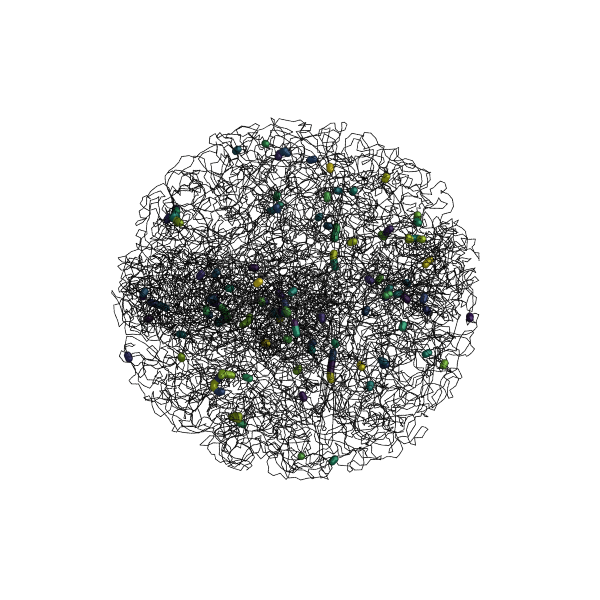

In [35]:
# Visualize new conformation
snapshot_relaxed = system.state.get_snapshot()
render.fresnel(snapshot_relaxed, show="loops", rescale_backbone_bonds=0.1).static()

In [36]:
# Update simulation engine
system.operations.remove(fire)
system.operations.remove(system.operations.writers[0])

system.operations.integrator = dpd_integrator
system.operations.writers.append(log.table_formatter(logger, period=10000))

In [37]:
# Run
steps_per_loop = extrusion_dict['3D_to_1D_steps']/extrusion_dict['velocity_multiplier']

for lef_positions in translocator.lef_trajectory:
    extrude.update_topology(system, lef_positions, thermalize=False)    
    system.run(steps_per_loop)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
      110000           5146.90668        0:00:00               1.28110          
      120000           3885.42867        0:00:00               2.05843          
      130000           4011.69237        0:00:00               2.16796          
      140000           4033.89281        0:00:00               2.10173          
      150000           3914.85678        0:00:00               2.18239          
      160000           4002.73554        0:00:00               2.11665          
      170000           3929.69984        0:00:00               2.12089          
      180000           4231.61163        0:00:00               2.12513          
      190000           4723.92347        0:00:00               2.11279          
      200000           3789.46567        0:00:00               2.08267          
      210000           3516.89524        0:00:00               2.13972          
      220000           3876.

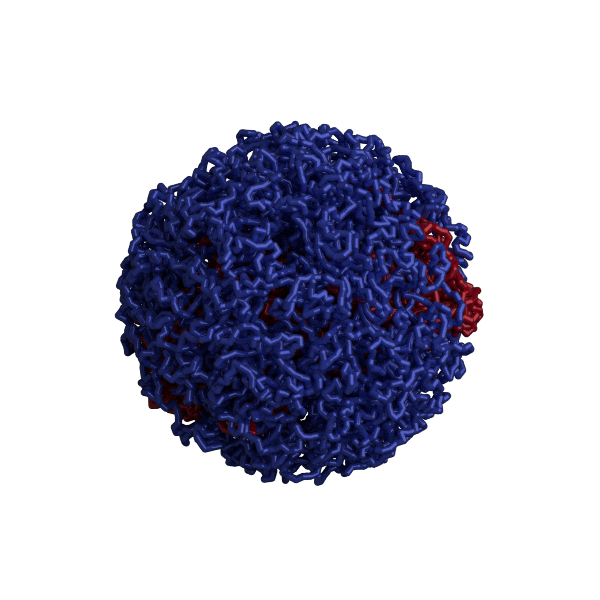

In [38]:
# Visualize new conformation
final_snapshot = system.state.get_snapshot()
render.fresnel(final_snapshot, show="compartments", cmap="coolwarm").static()

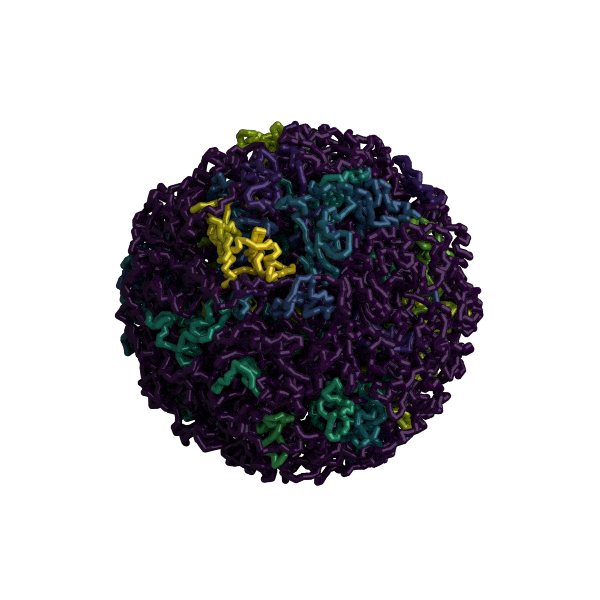

In [39]:
# Visualize individual loops
render.fresnel(final_snapshot, show="loops").static()